# LeNet5 Implementation from Scratch

In [6]:
#import package
import numpy as np 
import sys
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import time

In [7]:
from utils.LayerObjects import *
from utils.utils_func import *

In [8]:
import os
Task_name = 'Assignment1&2 dataset'
data_root = "/home/p88101029/"
raw_data_base = os.path.join(data_root,Task_name)
os.makedirs(raw_data_base, exist_ok=True)
listoffolder=sorted(os.listdir(raw_data_base), reverse=False)
import cv2
import numpy as np
from numpy import asarray
images = []
imagescat = []
imagesnames = []
for folder in listoffolder:
    images_path = os.path.join(raw_data_base,folder)
    address = sorted(os.listdir(images_path))
    for imgadd in address:
        imagescat.append(folder)
        imagesnames.append(imgadd)
        img=cv2.imread(os.path.join(images_path,imgadd))
        images.append(asarray(img))

In [9]:
imgs=[]
for i in images:
    img=cv2.resize(i,(64,64))
    imgs.append(img)

In [10]:
imagesarr=np.asarray(imgs)
imagescatarr=np.asarray(imagescat)

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(imagescatarr)
encoded_imagescatarr = encoder.transform(imagescatarr)
imagescatarr = np_utils.to_categorical(encoded_imagescatarr)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
import tensorflow as tf
X_trainvalid, X_test, y_trainvalid, y_test = train_test_split(imagesarr,imagescatarr, test_size=0.1, random_state=0)

split_indext = np.concatenate((np.ones(round(len(y_trainvalid)*0.8)), np.zeros(round(len(y_trainvalid)*0.2))), axis=None).astype(bool)
split_indexv = np.concatenate((np.zeros(round(len(y_trainvalid)*0.8)), np.ones(round(len(y_trainvalid)*0.2))), axis=None).astype(bool)

train_image, train_label = X_trainvalid[split_indext], y_trainvalid[split_indext]
valid_image, valid_label = X_trainvalid[split_indexv], y_trainvalid[split_indexv]
test_image, test_label = X_test, y_test
'''
train_image=tf.convert_to_tensor(train_image, dtype=tf.float32)
valid_image=tf.convert_to_tensor(valid_image, dtype=tf.float32)
test_image=tf.convert_to_tensor(test_image, dtype=tf.float32)
train_label=tf.convert_to_tensor(train_label, dtype=tf.float32)
valid_label=tf.convert_to_tensor(valid_label, dtype=tf.float32)
test_label=tf.convert_to_tensor(test_label, dtype=tf.float32)
'''
n_m, n_m_valid, n_m_test = len(train_label),len(valid_label), len(test_label)
print("The shape of training image:", train_image.shape)
print("The shape of validing image:", valid_image.shape)
print("The shape of testing image: ", test_image.shape)
print("Length of the training set: ", n_m)
print("Length of the validing set:", n_m_valid)
print("Length of the testing set: ", n_m_test)
print("Shape of a single image: ", train_image[0].shape)

The shape of training image: (46242, 64, 64, 3)
The shape of validing image: (11560, 64, 64, 3)
The shape of testing image:  (6423, 64, 64, 3)
Length of the training set:  46242
Length of the validing set: 11560
Length of the testing set:  6423
Shape of a single image:  (64, 64, 3)


In [13]:
def normalize(image):
    image = image/256
    return image
train_image = normalize(train_image)
valid_image = normalize(valid_image)
test_image  = normalize(test_image)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

inputs = tf.keras.Input(shape=(64, 64, 3))
x = Conv2D(filters=6, kernel_size=(5, 5), activation='tanh')(inputs)
x = MaxPooling2D(pool_size=(4, 4))(x)
x = Conv2D(filters=16, kernel_size=(5, 5), activation='tanh')(x)
x = MaxPooling2D()(x)
x = Conv2D(filters=120, kernel_size=(5, 5), activation='tanh')(x)
x = x[:,0,0,:]
x = Dense(units=120, activation='tanh')(x)
x = Dense(units=84, activation='tanh')(x)
outputs = Dense(units=50, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

acc_rate_list = []
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

st = time.time()
counter=0
best_acc=0
for epoch in range(100):
    history = model.fit(train_image, train_label, validation_data=(valid_image, valid_label), epochs=1, batch_size=256)
    print('Epoch:', epoch+1, '- Validation Accuracy:')
    acc_train, acc_test = history.history['accuracy'][0], history.history['val_accuracy'][0]
    acc_rate_list.append([acc_train, acc_test])
    if acc_test>best_acc:
        counter=0
        best_acc=acc_test
    else:
        counter+=1
        if counter == 10:
            break

print("Total time used: ", time.time() - st, "sec")

In [ ]:
# This shows the error rate of training and testing data after each epoch
acc_rate_list = np.array(acc_rate_list).T
x = np.arange(100)[0:acc_rate_list.shape[1]]
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.plot(x, acc_rate_list[0,:])
plt.plot(x, acc_rate_list[1,:])
plt.legend(['training data', 'validation data'], loc='upper right')
plt.show()

In [ ]:
predictionprob=model.predict(valid_image)

In [ ]:
prediction = np.argmax(predictionprob, axis = 1)
actual = np.argmax(valid_label.numpy(), axis = 1)
np.mean(prediction==actual)

In [ ]:
maxfive=np.argsort(predictionprob, axis=1)[:,-5:]
actual= np.argmax(valid_label.cpu().numpy(), axis = 1).reshape(-1,1)
np.mean((actual==maxfive).sum(-1))

In [ ]:
with tf.device('/GPU:0'):
    st = time.time()
    predictionprob=model.predict(test_image)
    print("Total time used: ", time.time() - st, "sec")    

In [ ]:
prediction = np.argmax(predictionprob, axis = 1)
actual = np.argmax(test_label.cpu().numpy(), axis = 1)
np.mean(prediction==actual)

In [ ]:
maxfive=np.argsort(predictionprob, axis=1)[:,-5:]
actual= np.argmax(test_label.cpu().numpy(), axis = 1).reshape(-1,1)
np.mean((actual==maxfive).sum(-1))

In [22]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.reset_default_graph()
tf.disable_eager_execution()
tf.disable_v2_behavior()

num_epoch = 100
batch_size = 256

x = tf.placeholder("float", [None,64,64,3])
y = tf.placeholder("float", [None,50])

conv1_w = tf.get_variable("conv1_w", [5,5,3,6], initializer=tf.truncated_normal_initializer(stddev=0.1))
conv1_b = tf.get_variable("conv1_b", [6], initializer=tf.constant_initializer(value=0))
conv1 = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], padding='VALID')
tanh1 = tf.nn.tanh( tf.nn.bias_add(conv1, conv1_b) )

pool1 = tf.nn.max_pool(tanh1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='VALID')

conv2_w = tf.get_variable("conv2_w", [5,5,6,16], initializer=tf.truncated_normal_initializer(stddev=0.1))
conv2_b = tf.get_variable("conv2_b", [16], initializer=tf.constant_initializer(value=0))
conv2 = tf.nn.conv2d(pool1, conv2_w, strides=[1,1,1,1], padding='VALID')
tanh2 = tf.nn.tanh( tf.nn.bias_add(conv2, conv2_b) )

pool2 = tf.nn.max_pool(tanh2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

conv3_w = tf.get_variable("conv3_w", [5,5,16,120], initializer=tf.truncated_normal_initializer(stddev=0.1))
conv3_b = tf.get_variable("conv3_b", [120], initializer=tf.constant_initializer(value=0))
conv3 = tf.nn.conv2d(pool2, conv3_w, strides=[1,1,1,1], padding='VALID')
tanh3 = tf.nn.tanh( tf.nn.bias_add(conv3, conv3_b) )
tanh3 = tanh3[:,0,0,:]

fc1_w = tf.get_variable("fc1_w", [120, 84], initializer=tf.truncated_normal_initializer(stddev=0.1))
fc1_b = tf.get_variable("fc1_b", [84], initializer=tf.constant_initializer(value=0.1))
fc1 = tf.nn.tanh( tf.matmul(tanh3, fc1_w) + fc1_b )

fc2_w = tf.get_variable("fc2_w", [84, 50], initializer=tf.truncated_normal_initializer(stddev=0.1))
fc2_b = tf.get_variable("fc2_b", [50], initializer=tf.constant_initializer(value=0.1))
y_hat = tf.matmul(fc1, fc2_w) + fc2_b

pred = tf.nn.softmax(y_hat)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_hat, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss_op)

correct = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

acc_rate_list = []
with tf.Session() as sess:
    sess.run(init)
    size = len(train_image)
    indices = np.arange(size)
    st = time.time()
    counter=0
    best_acc=0

    for epoch in range(num_epoch):
        ste = time.time()
        np.random.shuffle(indices)
        shuffled_x = train_image[indices]
        shuffled_y = train_label[indices]

        # Iterate over mini-batches
        num_batches = size // batch_size + 1
        for batch in range(num_batches):
            # Extract the current mini-batch
            batch_x = shuffled_x[batch * batch_size : min((batch + 1) * batch_size,size)]
            batch_y = shuffled_y[batch * batch_size : min((batch + 1) * batch_size,size)]
            sess.run(train_op, feed_dict={x: batch_x, y: batch_y})
        tra_loss, tra_acc = sess.run([loss_op, accuracy], feed_dict={x: train_image, y: train_label})
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={x: valid_image, y: valid_label})

        print("epoch " + str(epoch+1) + ", tra_loss= " + "{:.4f}".format(tra_loss) + ", tra_acc= " + "{:.4f}".format(tra_acc) + ", val_loss= " + "{:.4f}".format(val_loss) + ", val_acc= " + "{:.3f}".format(val_acc))
        print("Time used: ",time.time() - ste, "sec")
        acc_rate_list.append([tra_acc, val_acc])
        if val_acc>best_acc:
            counter=0
            best_acc=val_acc
        else:
            counter+=1
            if counter == 10:
                break
    print("Total time used: ", time.time() - st, "sec")
    st = time.time()
    predictionprob = sess.run(pred, feed_dict={x: test_image})
    print("Total time used: ", time.time() - st, "sec")  

epoch 1, tra_loss= 3.2411, tra_acc= 0.1497, val_loss= 3.2524, val_acc= 0.148
Time used:  51.55876708030701 sec
epoch 2, tra_loss= 3.1398, tra_acc= 0.1695, val_loss= 3.1603, val_acc= 0.171
Time used:  59.67525243759155 sec
epoch 3, tra_loss= 3.0027, tra_acc= 0.1988, val_loss= 3.0440, val_acc= 0.192
Time used:  67.50876212120056 sec
epoch 4, tra_loss= 2.9550, tra_acc= 0.2074, val_loss= 3.0073, val_acc= 0.193
Time used:  53.828572034835815 sec
epoch 5, tra_loss= 2.8838, tra_acc= 0.2256, val_loss= 2.9559, val_acc= 0.209
Time used:  66.0501754283905 sec
epoch 6, tra_loss= 2.8345, tra_acc= 0.2361, val_loss= 2.9202, val_acc= 0.215
Time used:  44.402666330337524 sec
epoch 7, tra_loss= 2.8223, tra_acc= 0.2366, val_loss= 2.9222, val_acc= 0.213
Time used:  53.0462703704834 sec
epoch 8, tra_loss= 2.7839, tra_acc= 0.2467, val_loss= 2.9036, val_acc= 0.218
Time used:  56.353713512420654 sec
epoch 9, tra_loss= 2.7205, tra_acc= 0.2597, val_loss= 2.8608, val_acc= 0.230
Time used:  35.458972454071045 sec

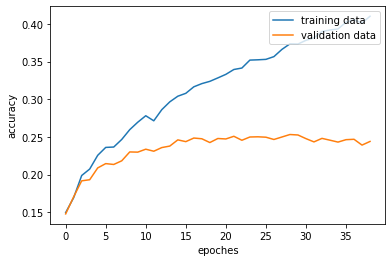

In [23]:
# This shows the error rate of training and testing data after each epoch
acc_rate_list = np.array(acc_rate_list).T
x = np.arange(100)[0:acc_rate_list.shape[1]]
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.plot(x, acc_rate_list[0,:])
plt.plot(x, acc_rate_list[1,:])
plt.legend(['training data', 'validation data'], loc='upper right')
plt.show()

In [25]:
prediction = np.argmax(predictionprob, axis = 1)
actual = np.argmax(test_label, axis = 1)
np.mean(prediction==actual)

0.2394519694846645

In [26]:
maxfive=np.argsort(predictionprob, axis=1)[:,-5:]
actual= np.argmax(test_label, axis = 1).reshape(-1,1)
np.mean((actual==maxfive).sum(-1))

0.5668690643001713